# LSTM Stock Predictor Using Closing Prices
In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Carnival Stock prices closing prices to predict the 11th day closing price.

We are:

Preparing the data for training and testing Building and train a custom LSTM RNN Evaluating the performance of the model

# Data Preparation
In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:

Use the window_data function to generate the X and y values for the model. Split the data into 70% training and 30% testing Apply the MinMaxScaler to the X and y values Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is: reshape((X_train.shape[0], X_train.shape[1], 1))

In [3]:
import numpy as np
import pandas as pd
import hvplot.pandas
import yfinance as yf

In [4]:
# Setting the random seed for reproducibility
# Note: It is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [6]:
# Downloading VIX OHLCV using yfinance
df = yf.download("^VIX", start="2016-01-02", end="2020-12-31", 
                      index_col="Date", infer_datetime_format=True, parse_dates=True)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,22.480000,23.360001,20.670000,20.700001,20.700001,0
2016-01-05,20.750000,21.059999,19.250000,19.340000,19.340000,0
2016-01-06,21.670000,21.860001,19.799999,20.590000,20.590000,0
2016-01-07,23.219999,25.860001,22.400000,24.990000,24.990000,0
2016-01-08,22.959999,27.080000,22.480000,27.010000,27.010000,0


In [4]:
# Creating a new dataframe with the close column and renaming it Vix_value
df = df[['Close']].copy()
df = df.rename(columns={'Close': 'vix_value'})
df['vix_value']=df['vix_value'].astype(int)
df = df.round(2)
df.head()

,vix_value
Date,
2020-03-02,33
2020-03-03,36
2020-03-04,31
2020-03-05,39
2020-03-06,41


In [61]:
# Loading the Volatility index data
#df = pd.read_csv('stock_data/vix.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
#df = df.drop(columns= "Open")
#df = df.rename(columns={'Close': 'vix_value'})
#df['vix_value']=df['vix_value'].astype(int) 
#df.index = df.index.normalize()
#df.head()

In [60]:
# Slicing the historical Volatility index data to Covid dates
##df_sliced = df.loc['2020-03-02':'2020-12-30']
#df_sliced.tail()

In [5]:
# Downloading Carnival OHLCV using yfinance
df2 = yf.download("CCL", start="2016-01-04", end="2020-12-31", 
                      index_col="Date", infer_datetime_format=True, parse_dates=True)
df2.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,20.120001,21.080000,20.030001,20.940001,20.940001,31385200
2020-12-24,20.980000,21.080000,20.430000,20.840000,20.840000,14819300
2020-12-28,21.309999,22.049999,21.020000,21.709999,21.709999,33112800
2020-12-29,22.219999,22.270000,21.360001,21.430000,21.430000,26851200
2020-12-30,21.520000,22.090000,21.379999,21.790001,21.790001,23606400


In [6]:
df2 = df2[['Close']].copy()
df2 = df2.round(2)
df2.head()

,Close
Date,
2020-03-02,33.06
2020-03-03,31.83
2020-03-04,32.46
2020-03-05,27.87
2020-03-06,27.15


In [7]:
# Loading the historical closing prices for Carnival
#df2 = pd.read_csv('stock_data/ccl.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
#df2 = df2.sort_index()
#df2.index = df2.index.normalize()
#df2.tail()

In [8]:
# Slicing the historical closing prices for Carnival Cruises to Covid dates
#df2_sliced = df2['2020-03-02':'2020-12-30']
#df2_sliced.head()

In [9]:
# Joining the data into a single DataFrame
df_joined = df.join(df2, how="inner")
df_joined.tail()

,vix_value,Close
Date,,
2020-12-23,23,20.94
2020-12-24,21,20.84
2020-12-28,21,21.71
2020-12-29,23,21.43
2020-12-30,22,21.79


In [10]:
df_joined.head()

,vix_value,Close
Date,,
2020-03-02,33,33.06
2020-03-03,36,31.83
2020-03-04,31,32.46
2020-03-05,39,27.87
2020-03-06,41,27.15


In [11]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df_joined, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df_joined) - window - 1):
        features = df_joined.iloc[i:(i + window), feature_col_number]
        target = df_joined.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [12]:
# Predicting Closing Prices using a 5 day window of previous closing prices
# Then, experimenting with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 5

# Column index 0 is the 'vix_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df_joined, window_size, feature_column, target_column)

In [13]:
# Using 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [14]:
from sklearn.preprocessing import MinMaxScaler
# Using the MinMaxScaler to scale data between 0 and 1.
# Creating a MinMaxScaler object
scaler = MinMaxScaler()
# Fitting the MinMaxScaler object with the features data X
scaler.fit(X)

# Scaling the features training and testing sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scaling the target training and testing sets
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [15]:
# Reshaping the features for the model
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Printing some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train_scaled[:3]} \n")
print (f"X_test sample values:\n{X_test_scaled[:3]}")

X_train sample values:
[[[0.20967742]
  [0.25806452]
  [0.17741935]
  [0.30645161]
  [0.33870968]]

 [[0.25806452]
  [0.17741935]
  [0.30645161]
  [0.33870968]
  [0.5483871 ]]

 [[0.17741935]
  [0.30645161]
  [0.33870968]
  [0.5483871 ]
  [0.43548387]]] 

X_test sample values:
[[[0.12903226]
  [0.09677419]
  [0.09677419]
  [0.09677419]
  [0.09677419]]

 [[0.09677419]
  [0.09677419]
  [0.09677419]
  [0.09677419]
  [0.09677419]]

 [[0.09677419]
  [0.09677419]
  [0.09677419]
  [0.09677419]
  [0.11290323]]]


## Build and Train the LSTM RNN
In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:

Define the model architecture Compile the model Fit the model to the training data

## Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the Vix model vs the closing price model.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [17]:
# Building the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# No need to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Defining the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train_scaled.shape[1], 1)))
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [18]:
# Compiling the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [19]:
# Summarizing the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 30)             3840      
_________________________________________________________________
dropout (Dropout)            (None, 5, 30)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 30)             7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 30)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [20]:
# Training the model
# Using at least 10 epochs
# Do not shuffle the data
# Experiementing with the batch size, but a smaller batch size is recommended
model.fit(X_train_scaled, y_train_scaled, epochs=10, shuffle=False, batch_size=10, verbose=1)

Epoch 1/10
15/15 [==============================] - 3s 6ms/step - loss: 0.1694
Epoch 2/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0624
Epoch 3/10
15/15 [==============================] - 0s 5ms/step - loss: 0.1294
Epoch 4/10
15/15 [==============================] - 0s 6ms/step - loss: 0.0616
Epoch 5/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0598
Epoch 6/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0587
Epoch 7/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 8/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 9/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 10/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0372


### Model Performance
In this section, you will evaluate the model using the test data.

You will need to:

1. Evaluate the model using the X_test and y_test data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values.
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the inverse_transform function to the predicted and y_test values to recover the actual closing prices.

In [21]:
# Evaluating the model
model.evaluate(X_test_scaled, y_test_scaled)

2/2 [==============================] - 1s 4ms/step - loss: 0.0511


0.051101963967084885

In [22]:
# Making some predictions
predicted = model.predict(X_test_scaled)

In [23]:
# Recovering the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

In [24]:
# Creating a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df_joined.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-10-02,15.03,15.576068
2020-10-05,15.16,15.607767
2020-10-06,14.96,15.606026
2020-10-07,15.19,15.601518
2020-10-08,15.99,15.589984


<AxesSubplot:title={'center':'Real Vs. Predicted Prices'}, xlabel='Date'>

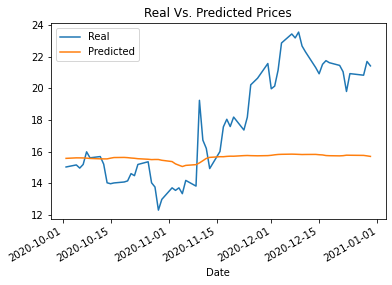

In [25]:
# Plotting the real vs predicted values as a line chart
stocks.plot(title="Real Vs. Predicted Prices")